In [1]:
from crear_dataset import *
from funcions_net import *
import numpy as np
import matplotlib.pyplot as plt
import pyreadstat
import pandas as pd
from preprocessing import *
from sklearn.model_selection import train_test_split
from func_sel import *
from funcions_net import *


In [2]:

df_orig, meta = pyreadstat.read_sav("CEJFEAjut2015Updated.sav")

df_variables = pd.read_csv("variables.csv", sep=';')

dict = create_dict(meta)

df_psico = dataset_psicologia(df_orig, dict,df_variables)

df = drop_all_columns(df_psico, meta, df_variables, dict)

df['temps_fins_reincidencia1a'] = df_orig['temps_fins_reincidencia1a']

df['temps_fins_reincidencia1a'] = df['temps_fins_reincidencia1a'].apply(lambda x: 1095 if x > 1095 else x)

[73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 2

In [3]:
print("Mirem quants nans tenim a cada columna")
netejat,df = neteja_na_columns(df, llindar=0.6)

df = omple_nans(df)

print("Columnes netejades")
## fem label encoding de les columnes categòriques
df = label_encoding(df)


Mirem quants nans tenim a cada columna
Columnes netejades


In [4]:
num_columnes = df.shape[1]
print("Hem netejat les columnes i hem fet label encoding")
print("Tenim ", num_columnes, " columnes")

Hem netejat les columnes i hem fet label encoding
Tenim  417  columnes


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='temps_fins_reincidencia1a'), df['temps_fins_reincidencia1a'], test_size=0.2,random_state=34)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_train = pd.DataFrame(X_train, columns=df.drop(columns='temps_fins_reincidencia1a').columns)

In [7]:
from enns2 import enns
from sklearn.metrics import mean_squared_error


# Create the model
selected_features = enns(X_train, y_train)



Iniciant ENNS amb EarlyStopping i validació interna...
Paràmetres: n_bootstraps=75, importance_threshold=0.5, min_selection_ratio=0.5


100%|██████████| 75/75 [24:27<00:00, 19.57s/it]


In [8]:
print("Selected features: ", selected_features.size)

Selected features:  407


In [9]:

# Create the new DataFrame with the selected features
X_train_selected = X_train.iloc[:, selected_features]

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [25,50,100],
    'max_depth': [5,10,15],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

# Realitzem el Grid Search
grid_search.fit(X_train_selected, y_train)

# Resultats
print("Millor paràmetre:", grid_search.best_params_)
print("Millor precisió:", -grid_search.best_score_)  # Negatiu perquè s'ha usat neg_mean_squared_error

# Mostrem la mitjana dels resultats de test
print("Mitjana dels resultats de test per cada combinació:")
print(np.mean(grid_search.cv_results_['mean_test_score'] * -1))  # Multipliquem per -1 per obtenir el MSE positiu

best_model = grid_search.best_estimator_


Millor paràmetre: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 25}
Millor precisió: 67876.69365217458
Mitjana dels resultats de test per cada combinació:
76285.51171962585



--- AVALUACIÓ FINAL EN TEST ---
MSE (Test): 189123.0915


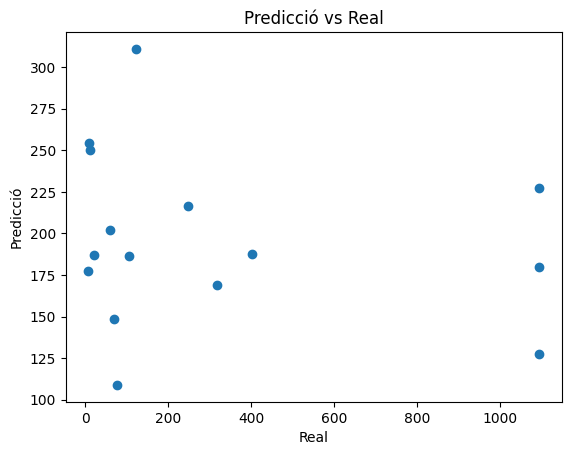

In [11]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error




X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=df.drop(columns='temps_fins_reincidencia1a').columns)

X_test_selected = X_test.iloc[:, selected_features]
# Fem les prediccions
y_test_pred = best_model.predict(X_test_selected)

# Calculem la mètrica MSE i R²
test_mse = mean_squared_error(y_test, y_test_pred)

print("\n--- AVALUACIÓ FINAL EN TEST ---")
print(f"MSE (Test): {test_mse:.4f}")


## plot de les prediccions
plt.scatter(y_test, y_test_pred)
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.title('Predicció vs Real')
plt.show()

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definim la graella d'hiperparàmetres per XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 1],      # regularització L1
    'reg_lambda': [1, 2],     # regularització L2
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    xgb,
    param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    verbose=1
)

# Realitzem el Grid Search
grid_search.fit(X_train_selected, y_train)

# Resultats
print("Millor paràmetre:", grid_search.best_params_)
print("Millor precisió:", -grid_search.best_score_)  # Negatiu perquè s'ha usat neg_mean_squared_error

# Mostrem la mitjana dels resultats de test per cada combinació
print("Mitjana dels resultats de test per cada combinació:")
print(np.mean(grid_search.cv_results_['mean_test_score'] * -1))

# Millor model trobat
best_model = grid_search.best_estimator_


Fitting 10 folds for each of 432 candidates, totalling 4320 fits



--- AVALUACIÓ FINAL EN TEST ---
MSE (Test): 186426.5653


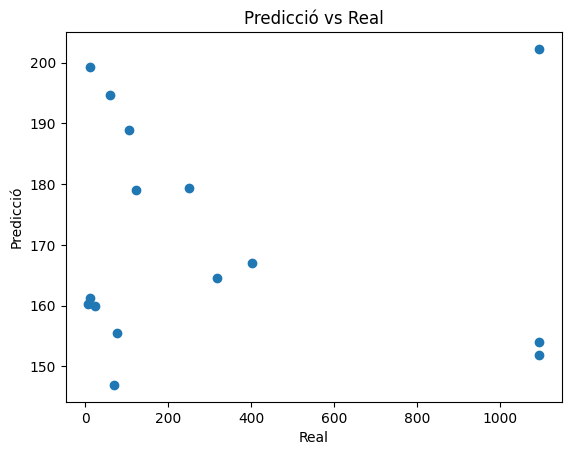

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Fem les prediccions
y_test_pred = best_model.predict(X_test_selected)

# Calculem la mètrica MSE i R²
test_mse = mean_squared_error(y_test, y_test_pred)

print("\n--- AVALUACIÓ FINAL EN TEST ---")
print(f"MSE (Test): {test_mse:.4f}")


## plot de les prediccions
plt.scatter(y_test, y_test_pred)
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.title('Predicció vs Real')
plt.show()